# Q1 Monthly and Annual Mean Wind Speeds in Canterbury Region
## Setup

In [25]:
import xarray as xr
import numpy as np #used for math
import salem #used for map features
import cartopy.crs as ccrs #module for orthographic projections
import glob 
import matplotlib.pyplot as plt
import matplotlib as mpl #I needed some other functions mpl has that mpl.plt does not
from dask.diagnostics import ProgressBar
import dask.array as da
import pandas as pd #for dataframe
from datetime import datetime #used to not need to explicitly write out my month/year lists
import seaborn as sns #used for better violin plots than mpl had (more versatile it seemed)
import cartopy as cart #used for ocean masking
import cmasher as cmr #I had to pip install cmasher as well to use this - this is for cmap restriction

In [26]:
#Location coords - I shared these with some classmates
Le_Bons_Bay=(-43.74366663321882, 173.06541840704594, "Le Bons Bay")
Kaikoura=(-42.38592402544425, 173.64832039863498, "Kaikoura")
Lyttelton_Harbour=(-43.60246071039801, 172.7199382231312, "Lyttelton Harbour")
Christchurch=(-43.53347089511781,172.63729024574516, "Christchurch")
Lake_Tekapo=(-44.00372763912672, 170.4753140312162, "Lake Tekapo")
Darfield=(-43.48688173398556, 172.1094604660583, "Darfield")
Rangiora=(-43.30367347710729, 172.59569463687257, "Rangiora")
Pukaki=(-44.23808335922984, 170.1184339493098, "Pukaki")
Winchmore=(-43.81325278290005, 171.72454388474932, "Winchmore")
Fairlie=(-44.09835912955975, 170.8325794766906, "Fairlie")
Mt_Cook_Village=(-43.734711452922255, 170.09719313677215, "Mt Cook Village")
Timaru=(-44.391397407133724, 171.23035358611267, "Timaru")
Culverden=(-42.77392043661266, 172.8515341421561, "Culverden")
Hanmer_Springs=(-42.5223094469903, 172.82857262789878, "Hanmer Springs")

# list of lists - each item in embedded list can be indexed to aquire lat/lon and city name
Cities_List=[Le_Bons_Bay, Kaikoura, Lyttelton_Harbour, Christchurch, 
             Lake_Tekapo, Darfield, Rangiora, Pukaki, Winchmore, 
             Fairlie, Mt_Cook_Village, Timaru, Culverden, Hanmer_Springs]

# indexing Cities_List to make a list of just the city names to use later as dataframe 
# column and violin plot axis, easier than typing them all out by hand
Cities=[] #
for i in Cities_List:
    Cities.append(i[2])

# setting dates for datelists to span...both month and year can use same start, but need different end points
start_date ="2000-01"
month_end_date ="2001-01"
data_end_date ="2020-12"

# honestly doing my datelists this way is probably not necesary but I had this code already 
# from something I tried in the first week of the assingment and didn't want it to go to waste
word_months = pd.date_range(start_date,month_end_date, 
                            freq='M').strftime("%b").tolist()

month_list = pd.period_range(start_date, month_end_date, 
                             freq='M').strftime("%m").tolist()
# word month list needs to be indexed one higher than numeric month list to be complete, so have to remove that extra from numeric
del month_list[-1] 

year_list = pd.period_range(start_date, data_end_date, 
                            freq='Y').strftime("%Y").tolist()

In [ ]:
from pathlib import Path
user_home = str(Path.home())
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=2, memory_limit='5GB',local_directory=user_home)
client

In [27]:
def data_by_month(month):
    global U_month_chunked, V_month_chunked
    """I set these global because you can only return 1 item, to return 2 I'd need to make them a tuple, which is inconvenient for what I want
    
    Retrieving all years of data for specified month only, chunking the data"""    
    U_month_chunked = xr.open_mfdataset('/mnt/data/MetService_WRF/U_*'+month+"01000*",chunks={"time":72,"height":1},parallel=True)
    V_month_chunked = xr.open_mfdataset('/mnt/data/MetService_WRF/V_*'+month+"01000*",chunks={"time":72, "height":1},parallel=True)
    return 

def LocationClip(u, v, city):   
    global U_Located, V_Located
    """I set these global because you can only return 1 item, to return 2 I'd need to make them a tuple, which is inconvenient for what I want
    
    Retrieving U and V data at specified city location at 10m (assignment did not technically specify a height to use)""" 
    U_Located=u.sel(height=10, lat=city[0],lon=city[1], method='nearest')
    V_Located=v.sel(height=10, lat=city[0],lon=city[1], method='nearest')
    return 


## Generating data for Dataframe

In [28]:
#      setting empty data frame to put all the data into:
AverageWSperCity=pd.DataFrame()

for city in Cities_List:
#         setting emtpy list for each city:
    MonthlyAverage=[] 
#         placeholder dataframe to fill with monthly average list to add to dataframe:
    placeholder=pd.DataFrame() 

    for month in month_list: 
#             pull all of xxx month and only xxx month from all 20 years:
        data_by_month(month) 
#             clip by location for each city using data from all year for just 1 month:
        LocationClip(U_month_chunked, V_month_chunked, city) 
#             calculate the windspeed using the data that is cropped to just 1 month and 1 location:
        Windspeed=np.sqrt((U_Located.U**2)+(V_Located.V**2))
#             calculate the average windspeed across the time axis (0): 
        AverageWS=np.mean(Windspeed, axis=0).compute()
#             pull just the numerical output (not whole array):
        SingleNum=AverageWS.item(0) 
#             append to the list for the specific city - citylist will have 12 items after month loop is done running:
        MonthlyAverage.append(SingleNum) 

#         emtpy DataFrame to use to append/concat the main dataframe. Emptied and re-written for each city
    placeholder=pd.DataFrame([MonthlyAverage], columns=word_months) 
#         placeholder dataframe is concatinated as a row at the botton of main dataframe
    AverageWSperCity=pd.concat([AverageWSperCity, placeholder])

#     converting all values to Km/hr, 
AverageWSperCity[AverageWSperCity.select_dtypes(include=['number']).columns] *= 3.6 #convert m/s to km/hr

#     add new column called city populated by city names as strings
AverageWSperCity["City"]=Cities 
#     setting the city column as the index
AverageWSperCity=AverageWSperCity.set_index("City") 

#     add column named Annual that is the average of rows (axis 1) onto the right side of dataframe, 
#     ignoring that the index values are not numeric
AverageWSperCity['Annual']=AverageWSperCity.mean(numeric_only=True, axis=1)

[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  1min 57.8s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  1min 38.8s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  1min 46.5s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  1min 44.4s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.7s
[#######################

## Formatting Dataframe

In [29]:
# setting the format dictionary for cell color to change to a peachy color when moused over
cell_hover_perams = {'selector': 'td:hover',
    'props': [('background-color', '#FFCBA5')]}
# setting the format dictionary for caption format to be larger and bold
caption_format_perams={'selector': 'caption', 
     'props': 'caption-side: top; font-size:1.5em; font-weight:bold'}

# setting table caption/title, decimal float, and hover and caption format dictionaries
Formatted_Avg_Windspeed_by_City=(AverageWSperCity
                  .style.set_caption("Average and Annual Windspeed Per City")
                  .format(precision=3)
                  .set_table_styles([cell_hover_perams, caption_format_perams]))

## Data Table

In [30]:
Formatted_Avg_Windspeed_by_City

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
City,,,,,,,,,,,,,
Le Bons Bay,16.407,15.835,15.377,14.824,15.518,15.849,15.447,15.134,16.402,16.667,16.219,16.121,15.817
Kaikoura,10.385,9.841,9.727,9.317,10.110,10.733,10.631,9.810,10.352,10.437,10.532,10.080,10.163
Lyttelton Harbour,14.973,14.235,13.300,11.905,11.881,11.607,11.135,11.624,12.541,13.864,14.232,14.917,13.018
Christchurch,11.533,10.527,9.574,8.199,7.933,7.644,7.458,8.076,9.564,10.684,11.059,11.564,9.485
Lake Tekapo,12.395,10.897,9.920,8.965,9.584,8.959,8.810,8.766,11.931,12.520,13.062,12.450,10.688
Darfield,16.414,15.485,15.192,13.962,14.750,14.408,14.328,14.142,16.370,16.399,16.088,15.964,15.292
Rangiora,14.080,12.724,11.958,10.465,10.902,10.778,10.690,10.700,12.529,13.196,13.663,13.695,12.115
Pukaki,9.612,8.359,7.426,6.664,7.074,6.559,6.346,6.246,8.551,9.302,10.001,9.553,7.974
Winchmore,11.620,10.620,10.064,9.386,9.922,9.631,9.764,9.855,11.366,11.606,11.686,11.737,10.605


In [5]:
AverageWSperCity #i have this hid here because i'm scared of losing these after they take soo long to run

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
City,,,,,,,,,,,,,
Le Bons Bay,16.407377,15.834590,15.376746,14.824323,15.517687,15.848846,15.446959,15.134500,16.402083,16.667400,16.218836,16.120557,15.816659
Kaikoura,10.384756,9.841433,9.726556,9.316714,10.110091,10.732603,10.630855,9.810034,10.352131,10.437152,10.532328,10.080211,10.162905
Lyttelton Harbour,14.973359,14.235127,13.299601,11.904825,11.880512,11.607117,11.134690,11.623662,12.540711,13.863723,14.231635,14.917121,13.017674
Christchurch,11.532974,10.527034,9.573540,8.198598,7.933496,7.643569,7.458499,8.075509,9.563969,10.683614,11.058852,11.564432,9.484507
Lake Tekapo,12.395269,10.897484,9.919843,8.964629,9.584464,8.959351,8.809917,8.766281,11.931008,12.519533,13.061626,12.450415,10.688318
Darfield,16.413550,15.485096,15.191766,13.962027,14.749705,14.408454,14.327737,14.142273,16.369637,16.399249,16.087994,15.964067,15.291796
Rangiora,14.080233,12.723872,11.958077,10.464960,10.901818,10.778368,10.689611,10.699914,12.529278,13.195843,13.663039,13.694837,12.114987
Pukaki,9.611751,8.359165,7.425864,6.664015,7.074278,6.559322,6.345539,6.246257,8.550564,9.302368,10.000616,9.553447,7.974432
Winchmore,11.619767,10.619862,10.063956,9.385965,9.921891,9.630502,9.763976,9.854834,11.365682,11.606167,11.685886,11.737266,10.604646


# Q2 Violin Plots of Windspeeds per City from 2000-2020

## Setup

In [3]:
# load in all wind data, chunked by time so lat/lon calls are intact
U_chunked = xr.open_mfdataset('/mnt/data/MetService_WRF/U_*',chunks={"time":500,"height":1},parallel=True)
V_chunked = xr.open_mfdataset('/mnt/data/MetService_WRF/V_*',chunks={"time":500, "height":1},parallel=True)

In [31]:
def flatten_windspeed_to_list(city,listname):
    """pull all wind data from selected city, calculate windspeed in km/hr"""
    LocationClip(U_chunked, V_chunked, city)
    Windspeed=(np.sqrt((U_Located.U**2)+(V_Located.V**2)))*3.6 #convert to km/h
    
    """flatten array/remove non-windspeed data with ravel (thanks kit),
    add the flattened array to specified list"""
    flattenedWindspeed=np.ravel(Windspeed)
    listname.append(flattenedWindspeed)
    return 

def WindspeedViolinPlot(listdata):
#     create figure and axis
    fig,ax=plt.subplots()
#     remove bottom and left spines (I just think it looks a little nicer personally)
    sns.despine(left=True, bottom=True)
#     make the plot pretty - specify colors and other style functions
    sns.set_theme(style="whitegrid", 
                  palette="pastel", 
#                   context="paper", 
                  font_scale = 1,
                  rc={'figure.dpi': 100, 'figure.figsize': (4, 10)})
#     plot the data, change color by city
    ax=sns.violinplot(data=listdata, hue_order=Cities)
    
#     add title, label axes and tick marks, rotate tick marks to be more readable 
    ax.set(title="Windspeed Distribution by City in Canterbury")
    ax.set_xticklabels(Cities)
    ax.set_ylabel("Windspeed")
    ax.set_xlabel("City")
    plt.xticks(rotation=45, ha="right")
    return 


## Generating data for Violin Plot

In [7]:
# make empty list so all locations can be plotted on same plot
flattened_windspeed_list=[]

for city in Cities_List:
    flatten_windspeed_to_list(city, flattened_windspeed_list) 
    
#i changed my list name to be more specific after running this but it took 6 hr to run 
# so im not re-running it but all instances of the list name have been renamed

[########################################] | 100% Completed | 37min 20.6s
[########################################] | 100% Completed | 30min 29.8s
[########################################] | 100% Completed | 33min 52.5s
[########################################] | 100% Completed | 34min  3.4s
[########################################] | 100% Completed | 32min 11.4s
[########################################] | 100% Completed | 33min 55.8s
[########################################] | 100% Completed | 30min 59.8s
[########################################] | 100% Completed | 33min  0.1s
[########################################] | 100% Completed | 30min 39.2s
[########################################] | 100% Completed | 24min 53.9s
[########################################] | 100% Completed | 24min 33.9s
[########################################] | 100% Completed | 22min 36.1s
[########################################] | 100% Completed | 23min 42.3s
[#####################################

## Violin Plot

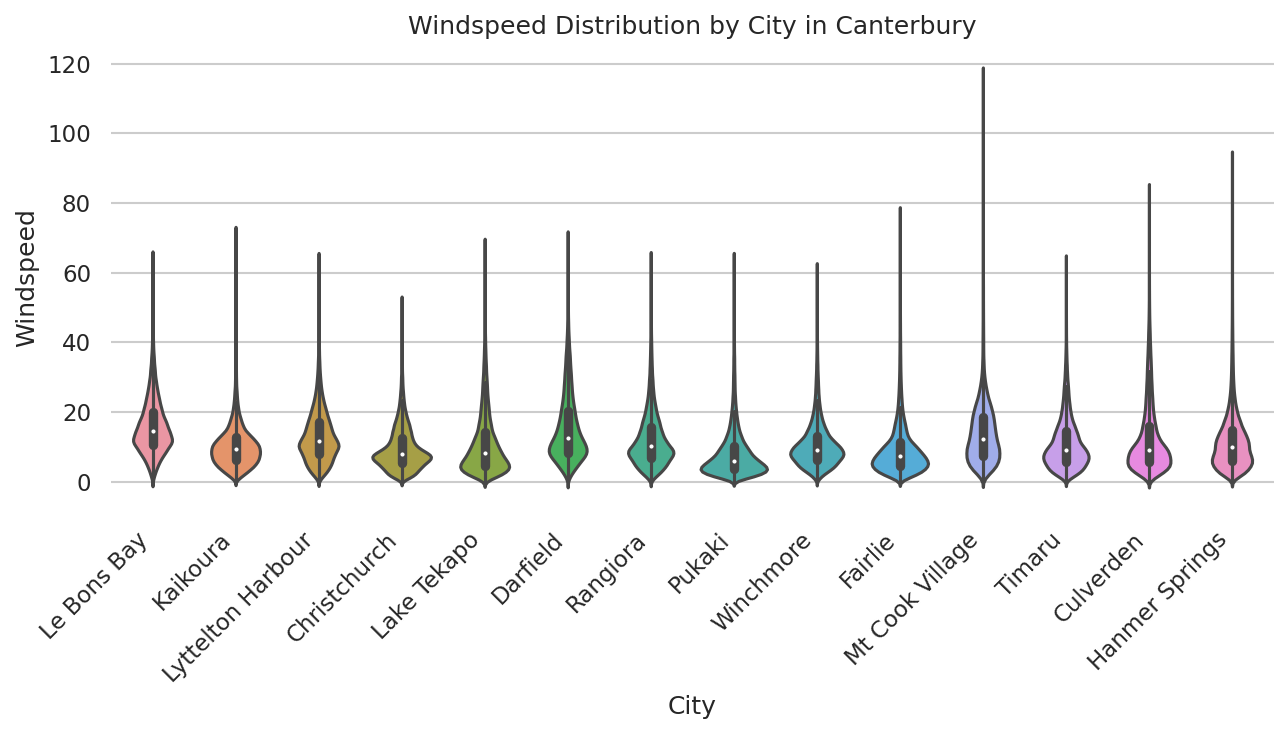

In [21]:
WindspeedViolinPlot(flattened_windspeed_list)

CPU times: user 1.87 s, sys: 12.8 s, total: 14.6 s
Wall time: 4.6 s


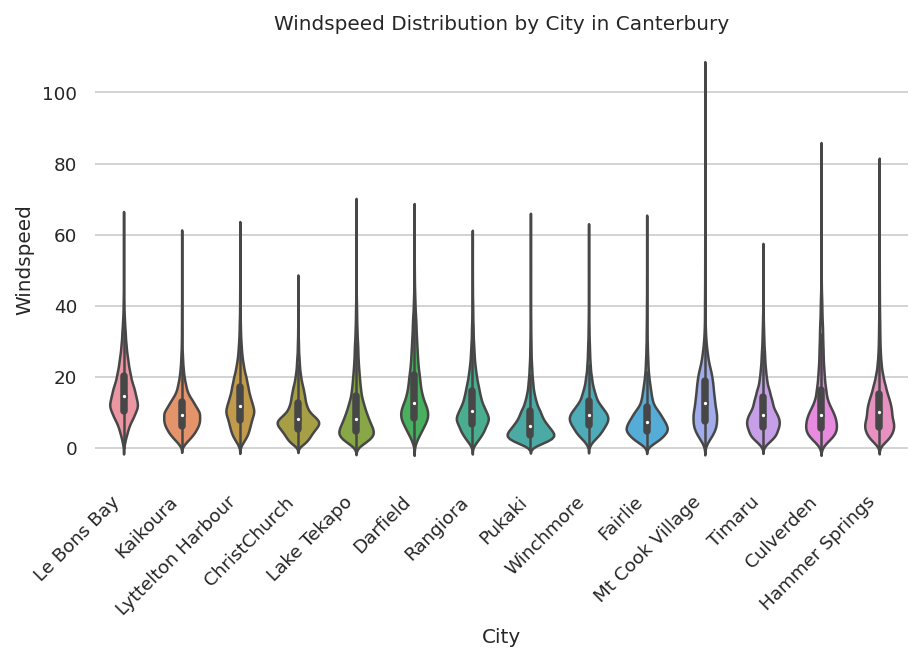

In [25]:
%%time
with ProgressBar():
    #putting in seprate cell so if I want to modify plots
    #I dont have to re-run the for loop
    fig,ax=plt.subplots()
    sns.despine(left=True, bottom=True)
    sns.set_theme(style="whitegrid", 
                  palette="pastel", 
                  context="paper", 
                  font_scale = 1,
                  rc={'figure.dpi': 150, 'figure.figsize': (5, 6)})
    ax=sns.violinplot(data=flat_city_list, hue_order=Cities)
    ax.set(title="Windspeed Distribution by City in Canterbury")
    ax.set_xticklabels(Cities)
    ax.set_ylabel("Windspeed")
    ax.set_xlabel("City")
    plt.xticks(rotation=45, ha="right")

# Q3 & Q4 Median Annual Average Temperature & Median Annual Total Rainfall

## Setup

In [32]:
def AnnualAverageTemp (year,targetlist):
#     open all temps for specified year
    Temp_by_year = xr.open_mfdataset('/mnt/data/MetService_WRF/T_'+year+"*",chunks={"time":75,"height":1},parallel=True)
#     take all temps at all lat/lons at height 0 (2m) for specified year
    Temp_by_year_heightIndexed=Temp_by_year.T[0,:,:,:]
#     average temps for the whole year across time, maintain dimentions as they are needed for plotting
    Yearly_average_temp=Temp_by_year_heightIndexed.mean(dim="time", keepdims= True )
#     add tempeerature average arrays to a list
    targetlist.append(Yearly_average_temp)
    return 

def TotalAnnualRainfall(year,targetlist):
#     open all rain data for specified year    
    Rain_by_year = (xr.open_mfdataset('/mnt/data/MetService_WRF/RAINNC_'+year+"*", chunks={"time":75,"height":1},parallel=True))
#     take all rainfall at all lat/lons at height 0 (10m) for specified year    
    Yearly_Rain=Rain_by_year.RAINNC[:,:,:]
#     sum all rainfall for the whole year across time, maintain dimentions as they are needed for plotting 
#     directions only say to do median annual total, not median annual total average so I did not average
    total_rain_by_year=Yearly_Rain.sum(dim="time", keepdims=True)
#     add rain total arrays to a list    
    targetlist.append(total_rain_by_year)
    return 

## Generating data 
### Q3 Data

In [33]:
# setting emtpy list for function outputs to fill - one list item per year
Avg_temp_by_year_list=[]

for year in year_list:
    AnnualAverageTemp(year, Avg_temp_by_year_list)

# finding the median between all 20 list items of the years 
# list indexed 0 to -1/last item, keeping dimentions since we need those to map
Median_temp_in_Kelvin=Avg_temp_by_year_list[0-(-1)].median(dim="time", keepdims=True)
# convert from Kelvin to Celcius
Median_Annual_Avg_Temp_in_C=(Median_temp_in_Kelvin-273) 

### Q4 Data

In [34]:
# setting emtpy list for function outputs to fill - one list item per year
Total_yearly_rain_list=[]

for year in year_list:
    TotalAnnualRainfall(year, Total_yearly_rain_list)

# finding the median between all 20 list items of the years 
# list indexed 0 to -1/last item, keeping dimentions since we need those to map
Median_Annual_Rain=Total_yearly_rain_list[0-(-1)].median(dim="time", keepdims=True)

## Map Setup

In [35]:
# There is a lot going on in this so I tried to space it out in a way that was more
# readable to me, though it makes it a pretty large cell/chunk/function

def NZ_Weather_Map(data, title="", color="plasma", 
                   intervals=None, restrict_color_bounds=False, 
                   scalemin=None, scalemax=None, 
                   scale_label="", extent=""): 
    '''this function has repeatability, but that versatility comes at the cost 
    of having a lot of optional perameters that can be specified, which I know is not ideal'''
    
    """Figure generation, projection designation, Coastlines and Ocean Masking"""
    plt.figure(constrained_layout=True)
    map_proj = ccrs.Orthographic(170, -45) # cartopy projection set
    ax = plt.axes(projection=map_proj) # add chosen projection to current axis
    ax.coastlines() # add coastlines to current axis
    ax.add_feature(cart.feature.OCEAN, zorder=2,  # mask out ocean on current axis with black 
                   edgecolor='black', facecolor='white') # borders, filling the ocean areas in with white
    
    """optional extent crop"""
#     if argument is present, an extent will be set, if no argument for extent is made, no
#     extent crop will be made. extent argument should be a list of coordinates for all 4 corners
    if extent:
        ax.set_extent(extent)
    else:
        None
    
    """Lat and Lon gridlines"""
    m=ax.gridlines(draw_labels=True, color='black', #lat/lon grids are drawn in black with 50% transparency
                 alpha=0.5, linestyle='--')
    
    """cleaning up the axis labels, rotating, and less clutter"""
#     assigning which axes will actually be drawn in the figure and 
#     which to omit, rotating x labels so they do not overlap
    m.bottom_labels=True; m.top_labels=False; m.left_labels=True; 
    m.right_labels=False; m.xlabel_style = {'rotation': 25}

    """Colormap assignment"""
#     selects color and how many intervals (integer) are made in colorbar. 
#     if intervals=None, scale will be continuous. if no argument given for intervals, defaults to "none"
#     if no color is specified, defaults to "plasma"
    cmap = cmr.get_sub_cmap(color, 0.15, 0.9, N=intervals)
    
    # if chosen colormap has end colors not desired (black & white in my case) this crops ends of the colormap, 
    # but the crop is not always desired when using other cmap colors to represent other things, hence if statments below
    
    if restrict_color_bounds == True:
        cmap=cmap
    elif restrict_color_bounds == False:
        cmap=mpl.cm.get_cmap(color, intervals)
    # restrict color bounds as true or false. if no argument given, false is assumed
    
    """plot the data, set the axis to the modified axis, transform"""
    m=data.plot(ax=ax, 
                transform=data.salem.cartopy(), 
                cmap=cmap, # cmap determined by restrict bounds argument. if no color is specified, defaults to "plasma"
                vmin=scalemin, # defaults to none if no scalemin specified
                vmax=scalemax)  # defauls to none if no scalemax specified
    
    """Titles, font and fig sizes"""
#     if title argument is present, title will be set to that, if no title argument
#     specified, title will default to "Plot"
    if title:
        title=title
    else:
        title="Plot"
    
    ax.set_title(title, fontsize=20) # sets plot title at font size 20
    fig=plt.gcf()
    fig.set_size_inches(10, 6) #set size of plot
    
#     variable dpi based on extent for better resolution
    if extent: 
        dpi=80
    else:
        dpi=100
        
    fig.set_dpi(dpi)
    
    """modifying and labeling colorbar"""
    
    cax = fig.get_axes()[1]
    plt.colorbar(m, cax=cax, label=scale_label, extend="both") # color bar for plot, axis assignment, labels colorbar

    return 

### Q3 Map Variables

In [36]:
# Temperature Map Perameters (honestly I'm sure theres a better way to to do this but 
# i've put a lot into this already and don't really have the time to go down this rabbit hole)
Temp_data= Median_Annual_Avg_Temp_in_C
Temp_title= "Median Annual Avg Temp from 2000-2020"
Temp_color="gist_earth"
Temp_intervals= 11
Temp_scalemin= 0
Temp_scalemax= 20
Temp_scale_label= "Temperature (C)"
extent=[170,174,-42,-45]
canterbury_title_extention=" in Canterbury"

### Q4 Map Variables

In [37]:
#Rain Map Perameters
Rain_data= Median_Annual_Rain
Rain_title= "Median Annual Rain from 2000-2020"
Rain_color="nipy_spectral_r"
Rain_restricted_color=True
Rain_intervals= 12
Rain_scalemin= 400 #min of data is slightly above 400
Rain_scalemax= 8000 #scale is below max of data but 8000 appears to be quite representative with relative resolution still intact
Rain_scalemax2= 2400 #reduced scale for national level resolution due to west coast
Rain_scale_label= "Rainfall (mm)"
# extent and canterbury title extention are defined in temp 
# perameters and can be brought through to rain functions

## Maps
### Q3 National Median Avg Temp Map

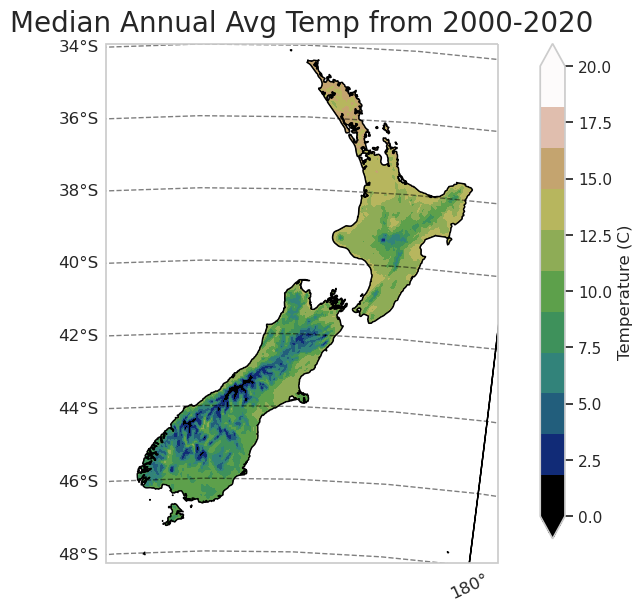

In [39]:
# run the function with inputs relavent to national map
National_Median_Average_Temp=(
    NZ_Weather_Map(
        data=Temp_data, title=Temp_title, 
        intervals=Temp_intervals, scalemin=Temp_scalemin, 
        scalemax=Temp_scalemax, scale_label=Temp_scale_label,
        color=Temp_color
    )
)

### Q3 Canterbury Median Annual Avg Temp Map

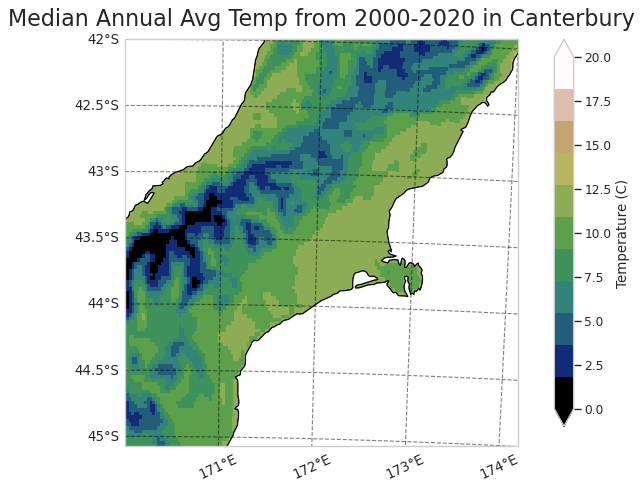

In [40]:
# run the function with inputs relavent to regional map
Canterbury_Median_Average_Temp=(
    NZ_Weather_Map(
    data=Temp_data, title=Temp_title+canterbury_title_extention,
    scalemin=Temp_scalemin, scalemax=Temp_scalemax,
    intervals=Temp_intervals, color=Temp_color, 
    scale_label=Temp_scale_label, extent=extent
    )
)

### Q4 National Median Annual Rainfall

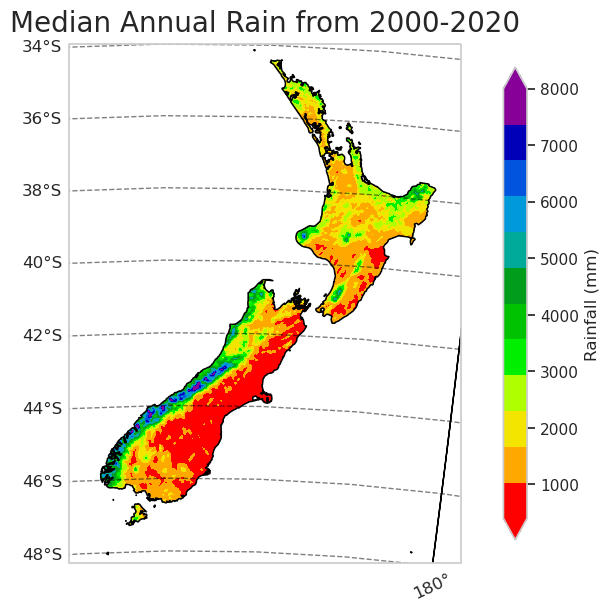

In [41]:
# run the function with inputs relavent to national map
National_Median_Total_Rainfall=(
    NZ_Weather_Map(
        data=Rain_data, title=Rain_title, 
        intervals=Rain_intervals, restrict_color_bounds=Rain_restricted_color,
        scalemin=Rain_scalemin, scalemax=Rain_scalemax, 
        scale_label=Rain_scale_label, color=Rain_color
    )
)

### Q4 Canterbury Median Annual Rainfall

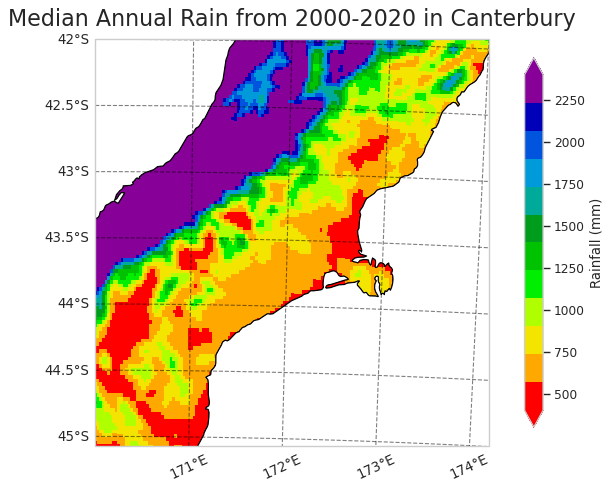

In [42]:
# run the function with inputs relavent to regional map
Canterbury_Median_Total_Rainfall=(
    NZ_Weather_Map(
        data=Rain_data, title=Rain_title+canterbury_title_extention, 
        intervals=Rain_intervals, restrict_color_bounds=Rain_restricted_color,
        scalemin=Rain_scalemin, scalemax=Rain_scalemax2, 
        scale_label=Rain_scale_label, color=Rain_color,
        extent=extent
    )
)